<a href="https://colab.research.google.com/github/Bayzid03/LangGraph-Hub/blob/main/Weekend_Activity_Planner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Still Working on this project

In [ ]:
!pip install langgraph langchain-google-genai python-dotenv

In [10]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from dotenv import load_dotenv
import random

In [11]:
from google.colab import userdata

# Explicitly get the API key from Colab secrets
api_key = userdata.get('GEMINI_API_KEY')

# Pass the API key to the ChatGoogleGenerativeAI model
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-05-20", temperature=0.7, google_api_key=api_key)

In [12]:
# Define Agent state
class WeekendPlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    location: str
    preferences: List[str]
    weather_info: str
    weekend_plan: str

# Prompt templates
weather_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a weather assistant. Provide a realistic weekend weather forecast for {location}. Include Saturday and Sunday conditions, temperature, and any weather advisories."),
    ("human", "What's the weather forecast for this weekend in {location}?"),
])

weekend_plan_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful weekend activity planner. Create a comprehensive 2-day weekend plan for {location} based on the user's preferences: {preferences} and current weather conditions: {weather_info}.

Structure your response as:
**SATURDAY**
- Morning (9 AM - 12 PM): [Activity]
- Afternoon (12 PM - 5 PM): [Activity]
- Evening (5 PM - 9 PM): [Activity]

**SUNDAY**
- Morning (9 AM - 12 PM): [Activity]
- Afternoon (12 PM - 5 PM): [Activity]
- Evening (5 PM - 9 PM): [Activity]

Consider weather conditions and provide specific locations, addresses when possible, and brief descriptions of each activity."""),
    ("human", "Create a weekend activity plan for me."),
])

In [13]:
# Defining Agent Functions
def input_location(state: WeekendPlannerState) -> WeekendPlannerState:
    print("Please enter your city/location for the weekend activities:")
    user_message = input("Your input: ")
    return {
        **state,
        "location": user_message,
        "messages": state['messages'] + [HumanMessage(content=user_message)],
    }

def input_preferences(state: WeekendPlannerState) -> WeekendPlannerState:
    print(f"Please enter your activity preferences for {state['location']} (comma-separated):")
    print("Examples: outdoor activities, museums, restaurants, shopping, nightlife, cultural sites, adventure sports, relaxing activities")
    user_message = input("Your input: ")
    return {
        **state,
        "preferences": [preference.strip() for preference in user_message.split(',')],
        "messages": state['messages'] + [HumanMessage(content=user_message)],
    }

def check_weather(state: WeekendPlannerState) -> WeekendPlannerState:
    print(f"Checking weather forecast for {state['location']}...")

    # Get weather forecast using LLM
    response = llm.invoke(weather_prompt.format_messages(location=state['location']))
    weather_info = response.content

    print(f"\nWeather Forecast:")
    print(weather_info)
    print("\n" + "="*50 + "\n")

    return {
        **state,
        "weather_info": weather_info,
        "messages": state['messages'] + [AIMessage(content=weather_info)],
    }

def create_weekend_plan(state: WeekendPlannerState) -> WeekendPlannerState:
    print(f"Creating weekend activity plan for {state['location']}...")
    print(f"Based on preferences: {', '.join(state['preferences'])}")
    print("Considering weather conditions...\n")

    response = llm.invoke(weekend_plan_prompt.format_messages(
        location=state['location'],
        preferences=", ".join(state['preferences']),
        weather_info=state['weather_info']
    ))

    print("🎉 Your Weekend Activity Plan:")
    print("="*50)
    print(response.content)
    print("="*50)

    return {
        **state,
        "messages": state['messages'] + [AIMessage(content=response.content)],
        "weekend_plan": response.content,
    }

In [14]:
# Create and Compile the Graph
workflow = StateGraph(WeekendPlannerState)

workflow.add_node("input_location", input_location)
workflow.add_node("input_preferences", input_preferences)
workflow.add_node("check_weather", check_weather)
workflow.add_node("create_weekend_plan", create_weekend_plan)

workflow.set_entry_point("input_location")

workflow.add_edge("input_location", "input_preferences")
workflow.add_edge("input_preferences", "check_weather")
workflow.add_edge("check_weather", "create_weekend_plan")
workflow.add_edge("create_weekend_plan", END)

app = workflow.compile()

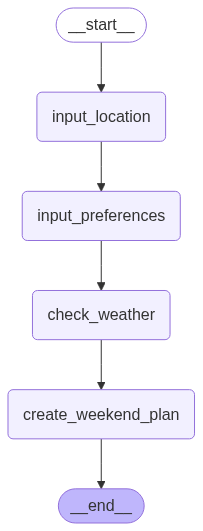

In [15]:
# Display the graph structure
display(Image(app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [16]:
# Define the function that runs the graph
def run_weekend_planner(user_request: str):
    print(f"🌟 Initial Request: {user_request}\n")
    print("="*50)

    state = {
        "messages": [HumanMessage(content=user_request)],
        "location": "",
        "preferences": [],
        "weather_info": "",
        "weekend_plan": "",
    }

    for output in app.stream(state):
        pass  # The nodes themselves handle all printing

    print("\n🎊 Weekend planning completed! Have a great weekend!")

if __name__ == "__main__":
    user_request = "I want to plan activities for this weekend."
    run_weekend_planner(user_request)

🌟 Initial Request: I want to plan activities for this weekend.

Please enter your city/location for the weekend activities:
Your input: Dhaka
Please enter your activity preferences for Dhaka (comma-separated):
Examples: outdoor activities, museums, restaurants, shopping, nightlife, cultural sites, adventure sports, relaxing activities
Your input: museums
Checking weather forecast for Dhaka...

Weather Forecast:
Here's your weekend weather forecast for Dhaka, bringing you the latest updates for Saturday and Sunday:

**Overall Outlook:**
Expect a hot and very humid weekend in Dhaka, with a mix of sunshine and clouds. There's a moderate to high chance of isolated to scattered thundershowers, particularly during the late afternoon or evening hours, which could bring temporary relief from the heat.

---

### **Saturday, [Current Date + 1 or 2 days for Saturday]**

*   **Conditions:** The day is expected to start mostly sunny and clear, but haze will be present. As the day progresses, clouds